In [1]:
from __future__ import print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib.layers import fully_connected, batch_norm

from utils import *

Run the following code to apply the slurm restriction

In [2]:
import os
NUM_THREADS = int(os.environ['OMP_NUM_THREADS'])
sess = tf.Session(config=tf.ConfigProto(
    intra_op_parallelism_threads=NUM_THREADS,
    inter_op_parallelism_threads=NUM_THREADS))

Convenient functions to show the running time

In [3]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

All the hyperparameters

In [47]:
batch_size = 64
number_inputs = 66
number_outputs = 8
seq_len = 300 # max 700
learning_rate = 0.001
val_interval = batch_size * 5
print_interval = batch_size * 10
samples_to_process = 1.5e4

Load all the data

In [48]:
# Get all the data
trainList_addr = './data/trainList'
validList_addr = './data/validList'
testList_addr = './data/testList'

start = time.time()
train_list, train_len_list = read_list(trainList_addr)
valid_list, valid_len_list = read_list(validList_addr)
test_list, test_len_list = read_list(testList_addr)

train_generator = generate_batch(train_list, train_len_list,
                                 max_seq_length=seq_len,
                                 batch_size=batch_size)

X_train, t_train, len_train = train_generator.next()
# X_train, t_train, len_train = read_data(train_list, train_len_list,
#                                         max_seq_length=seq_len)
X_valid, t_valid, len_valid = read_data(valid_list, valid_len_list,
                                        max_seq_length=max(valid_len_list))
X_test, t_test, len_test = read_data(test_list, test_len_list,
                                     max_seq_length=max(test_len_list))

timeSpent = time.time() - start
print("Time spent loading data: {}".format(asMinutes(timeSpent)))
print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test:", X_test.shape)

Time spent loading data: 0m 39s
X_train: (64, 300, 66)
X_valid: (1267, 683, 66)
X_test: (1267, 687, 66)


In [49]:
reset_default_graph()

X_input = tf.placeholder(tf.float32, shape=[None, None, number_inputs], name='X_input')
X_length = tf.placeholder(tf.int32, shape=[None,], name='X_length')
t_input = tf.placeholder(tf.int32, shape=[None, None], name='t_input')

num_units_encoder = 100
num_units_l1 = 100

cell_fw = tf.nn.rnn_cell.GRUCell(num_units_encoder)
cell_bw = tf.nn.rnn_cell.GRUCell(num_units_encoder)
#enc_cell = tf.nn.rnn_cell.OutputProjectionWrapper(enc_cell, number_outputs)
enc_outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw=cell_fw, cell_bw=cell_bw, inputs=X_input,
                                                 sequence_length=X_length, dtype=tf.float32)
enc_outputs = tf.concat(enc_outputs, 2)
outputs = tf.reshape(enc_outputs, [-1, num_units_encoder*2])
l1 = fully_connected(outputs, num_units_l1, normalizer_fn=batch_norm)
l_out = fully_connected(l1, number_outputs, activation_fn=None)

batch_size_shp = tf.shape(enc_outputs)[0]
seq_len_shp = tf.shape(enc_outputs)[1]
l_out_reshape = tf.reshape(l_out, [batch_size_shp, seq_len_shp, number_outputs])

y = l_out_reshape

In [50]:
# Calculate loss
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=t_input, logits=y)
loss = tf.reduce_mean(crossent)
# Calculate accuracy. Need to exclude the padded zeros.
predictions = tf.to_int32(tf.argmax(y, 2))
correct = tf.to_float(tf.equal(predictions, t_input))
accuracy = tf.reduce_mean(correct)

# use global step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)
# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(learning_rate)
# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [52]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.4)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# sess.run(tf.global_variables_initializer())

print("=" * 10 + "validating the model"+ "=" * 10)
# test validation part
sess.run(tf.global_variables_initializer())
feed_dict = {X_input: X_valid, X_length: len_valid, t_input: t_valid}
fetches = [y, t_input, predictions, crossent]
res = tuple(sess.run(fetches=fetches, feed_dict=feed_dict))
print("y:", res[0].shape)
print("t_input", res[1].shape)
print("predictions", res[2].shape)
print("Cross Entropy", res[3].shape)
# print(res[0][0, 0:20, :])
print(res[0][0, 0:5, :])
print(res[2][0, 0:5])
print("=" * 10 + "Model validation finished"+ "=" * 10)

==========validating the model==========
y: (1267, 683, 8)
t_input (1267, 683)
predictions (1267, 683)
Cross Entropy (1267, 683)
[[ 0.86243993 -0.79209489  1.38405383 -0.37650916 -0.06673558 -2.23163748
  -0.10650797  0.5113883 ]
 [ 0.62592047 -1.19165123  1.2891928  -0.04594254  0.06192031 -2.11360025
   0.35889208  0.50057006]
 [ 0.71294576 -1.52190411  1.98414099  0.21685544 -1.11758244 -1.72380698
   0.60148942  0.37680596]
 [ 0.87787098 -1.78982639  2.51424885 -0.05778873 -1.15209472 -1.27124071
  -0.25816196 -0.14460769]
 [ 0.36189899 -2.52509165  2.08530021  0.44635901 -1.19450843 -1.19696116
   0.62170786 -0.60141462]]
[2 2 2 2 2]
==========Model validation finished==========


In [53]:
samples_processed = 0
samples_val = []
costs, accs_val = [], []
saver1 = tf.train.Saver()

sess.run(tf.global_variables_initializer())
while samples_processed < samples_to_process:
    # make fetches
    fetches_tr = [train_op, loss, accuracy]
    # set up feed dict
    feed_dict_tr = {X_input: X_train, X_length: len_train,
                    t_input: t_train}
    # run the model
    res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
    _, batch_cost, batch_acc = res
    samples_processed += batch_size
    
    #validation data
    if samples_processed % val_interval == 0:
        fetches_val = [accuracy, y]
        feed_dict_val = {X_input: X_valid, X_length: len_valid,
                         t_input: t_valid}
        res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
        
        costs += [batch_cost]
        acc_val, output_val = res
        samples_val += [samples_processed]
        accs_val += [acc_val]

        if samples_processed % print_interval == 0:
            print("samples_processed: %d, batch_cost: %.2f, validation_accs: %.4f" % \
                  (samples_processed, batch_cost, acc_val))

saver1.save(sess, './bi_gru_300_dp')

samples_processed: 640, batch_cost: 0.98, validation_accs: 0.8639
samples_processed: 1280, batch_cost: 0.74, validation_accs: 0.8781
samples_processed: 1920, batch_cost: 0.64, validation_accs: 0.8911
samples_processed: 2560, batch_cost: 0.59, validation_accs: 0.8971
samples_processed: 3200, batch_cost: 0.56, validation_accs: 0.8998
samples_processed: 3840, batch_cost: 0.54, validation_accs: 0.9010
samples_processed: 4480, batch_cost: 0.53, validation_accs: 0.9017
samples_processed: 5120, batch_cost: 0.52, validation_accs: 0.9024
samples_processed: 5760, batch_cost: 0.51, validation_accs: 0.9028
samples_processed: 6400, batch_cost: 0.50, validation_accs: 0.9031
samples_processed: 7040, batch_cost: 0.49, validation_accs: 0.9033
samples_processed: 7680, batch_cost: 0.48, validation_accs: 0.9035
samples_processed: 8320, batch_cost: 0.47, validation_accs: 0.9035
samples_processed: 8960, batch_cost: 0.46, validation_accs: 0.9033
samples_processed: 9600, batch_cost: 0.45, validation_accs: 0.9

'./bi_gru_300_dp'

In [54]:
fetches_test = [accuracy, y, predictions]
feed_dict_test = {X_input: X_test, X_length: len_test,
                 t_input: t_test}
res = tuple(sess.run(fetches=fetches_test, feed_dict=feed_dict_test))

acc_test, output_test, predictions = res
print("Test Accuracy: {:.4f}".format(acc_test))
print(predictions[0, :])
print(t_test[0, :])

Test Accuracy: 0.9009
[0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 0 2 2 2 0 0 0 2 2 2 2 0
 7 6 6 0 0 0 0 3 7 6 2 2 2 2 2 2 2 2 0 7 7 6 6 7 6 2 2 2 2 2 2 0 5 5 5 5 5
 5 5 5 5 5 5 7 3 0 0 7 7 6 2 2 2 2 0 0 0 6 6 6 0 0 6 7 0 0 6 0 0 2 2 2 2 2
 0 0 0 0 5 5 5 5 0 0 7 7 6 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 7 7 0 6 6 6 6 0 7 0 2 2 2 2 2 5 5 5 5 5 5 5 6 0 0 0 0 5 5 5 5 5 5 5
 5 5 5 5 5 7 0 2 2 2 2 2 0 0 0 0 0 7 7 7 6 0 0 0 0 0 0 0 0 0 0 6 6 6 6 0 5
 3 3 6 6 7 6 6 7 7 2 2 2 2 2 2 0 7 0 7 2 2 2 2 2 2 2 2 2 2 2 2 0 5 5 5 5 5
 5 5 5 5 5 5 7 0 5 5 5 5 7 5 5 5 5 5 5 5 5 7 7 6 0 0 0 0 6 6 6 7 0 5 5 5 5
 5 5 5 5 5 5 0 0 6 6 2 2 2 2 2 2 2 0 0 0 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

In [ ]:
# with open("feat66_len300_dynamic_padding.txt","w") as f:
#     for (sample_val, acc_val, cost) in zip(samples_val, accs_val, costs):
#         f.write("{0},{1},{2}\n".format(sample_val, acc_val, cost))

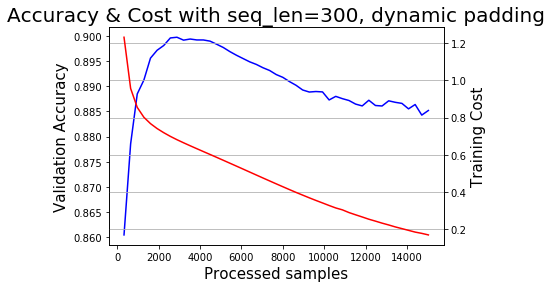

In [45]:
fig, ax1 = plt.subplots()
plt.plot(samples_val, accs_val, 'b-')
ax1.set_ylabel('Validation Accuracy', fontsize=15)
ax1.set_xlabel('Processed samples', fontsize=15)
plt.title('Accuracy & Cost with seq_len=300, dynamic padding', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(samples_val, costs, 'r-')
ax2.set_ylabel('Training Cost', fontsize=15)
plt.grid('on')
plt.savefig("out.png")
plt.show()

In [ ]:
samples_30, accs_30, costs_30 = [], [], []
with open("feat66_len30.txt","r") as f:
    for line in f:
        line = line.split(',')
        samples_30.append(line[0])
        accs_30.append(line[1])
        costs_30.append(line[2])

In [ ]:
fig, ax1 = plt.subplots()
plt.plot(samples_30, accs_30, 'b-')
ax1.set_ylabel('Validation Accuracy', fontsize=15)
ax1.set_xlabel('Processed samples', fontsize=15)
plt.title('Accuracy & Cost with seq_len=30', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(samples_30, costs_30, 'r-')
ax2.set_ylabel('Training Cost', fontsize=15)
plt.grid('on')
plt.savefig("out.png")
plt.show()

In [ ]:
samples_300, accs_300, costs_300 = [], [], []
with open("feat66_len300.txt","r") as f:
    for line in f:
        line = line.split(',')
        samples_300.append(line[0])
        accs_300.append(line[1])
        costs_300.append(line[2])

In [ ]:
fig, ax1 = plt.subplots()
plt.plot(samples_300, accs_300, 'b-')
ax1.set_ylabel('Validation Accuracy', fontsize=15)
ax1.set_xlabel('Processed samples', fontsize=15)
plt.title('Accuracy & Cost with seq_len=300', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(samples_300, costs_300, 'r-')
ax2.set_ylabel('Training Cost', fontsize=15)
plt.grid('on')
plt.savefig("out.png")
plt.show()